# Problem 1: Scraping house prices

In [7]:
'''
Author: amamiya-yuuko-1225 1913250675@qq.com
Date: 2024-11-11 11:33:16
LastEditors: amamiya-yuuko-1225 1913250675@qq.com
Description: 
'''
import pandas as pd
from bs4 import BeautifulSoup

map_swe_month_to_eng_abbr = {
    "januari": "Jan",
    "februari": "Feb",
    "mars": "Mar",
    "april": "Apr",
    "maj": "May",
    "juni": "Jun",
    "juli": "Jul",
    "augusti": "Aug",
    "september": "Sep",
    "oktober": "Oct",
    "november": "Nov",
    "december": "Dec"
}

'''
description: uniformize date like "10-Feb-2021".
param {str} s: raw date
return {str} formated date
'''
def uniformize_date(s: str) -> str:
    if " " not in s: 
        i = s.rfind('-')
        return s[: i + 1] + "20" + s[i + 1: ]
    else:
        ss = s.split(" ")
        return '-'.join([ss[0], map_swe_month_to_eng_abbr[ss[1]], ss[2]])

'''
description: scrape advertisements from a single html
param {str} path of the html file
return {pd.DataFrame} a pivot table of advertisements
'''
def extract_df_from_html(path: str) -> pd.DataFrame:
    #Reading the HTML File
    with open(path, 'r') as f:
        html = f.read()
    
    #Parsing the HTML    
    soup = BeautifulSoup(html, 'html.parser') 
    
    # Initialize an Empty List
    ad_s_list = list()    #This line creates an empty list named "names"

    #iterate all advertisements
    for cell in soup.find_all('li',class_='sold-results__normal-hit'):
        #store attributes of an ad
        ad_dict = {}

        raw_date = cell.find("span", class_="hcl-label hcl-label--state hcl-label--sold-at").text.strip().replace("Såld ", "")
        ad_dict["Date of sale (dd-m-yyyy)"] = uniformize_date(raw_date)

        ad_dict["Address"] = cell.find("h2", class_="sold-property-listing__heading qa-selling-price-title hcl-card__title").text.strip()

        ad_dict["Location"] = cell.find("div", class_="sold-property-listing__location").div.find_all(string=True, recursive=False)[1].replace(' ', '').replace('\n', '')

        area_and_rum = cell.find("div", class_="sold-property-listing__subheading sold-property-listing__area").text.replace(' ', '').replace('\n', '').split("\u00A0")
        #area_and_rum: ['161+55', 'm²', '5', 'rum']
        ad_dict["Area (m^2)"] = area_and_rum[area_and_rum.index('m²') - 1] if 'm²' in area_and_rum else 'NaN'
      
        ad_dict["No. of rooms"] = area_and_rum[area_and_rum.index('rum') - 1] if 'rum' in area_and_rum else 'NaN'

        land_area_element = cell.find("div", class_="sold-property-listing__land-area")
        ad_dict["Area of the plot (m^2)"] = land_area_element.text.replace(" ", '').replace('\n', '').replace('\xa0', '')[: -6:] if land_area_element != None else "NaN"

        index_of_slutpris = cell.text.find("Slutpris")
        ad_dict["Closing price (kr)"] = cell.text[index_of_slutpris + len("Slutpris"): cell.text.find("kr", index_of_slutpris): ].replace(" ", '').replace("\u00A0", '')

        ad_s = pd.Series(ad_dict)

        ad_s_list.append(ad_s)
        
    df = pd.concat(ad_s_list, axis = 1) 
    return df.T

In [8]:
import os
DATA_DIR = "./kungalv_slutpriser"

df_list = []

#iterate all html files, scrape and combine data
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        df = extract_df_from_html(os.path.join(root, f))
        df_list.append(df)

data = pd.concat(df_list)

data.to_csv("data.csv", index=None, encoding="UTF-8")

# Problem 2: Analyzing 2022 house sales

## 2.1 Five number summary

In [10]:
# read csv file
data = pd.read_csv('data.csv')

# # only data from 2022 is retained
data = data[data['Date of sale (dd-m-yyyy)'].apply(lambda x: x[-4:]) == '2022'] 

# if data.empty:
#     print("Data for 2022 is not available.")

# get closing prices
closing_prices = data['Closing price (kr)']

# calculate five number summary
minimum = closing_prices.min()
maximum = closing_prices.max()
median = closing_prices.median()
q1 = closing_prices.quantile(0.25)
q3 = closing_prices.quantile(0.75)

print(f"Minimum: {minimum}")
print(f"Lower quartile: {q1}")
print(f"Median: {median}")
print(f"Upper quartile: {q3}")
print(f"Maximum: {maximum}")


Minimum: 1650000
Lower quartile: 4012500.0
Median: 5000000.0
Upper quartile: 5795000.0
Maximum: 10500000


## 2.2 histogram of the closing prices

bin = 14


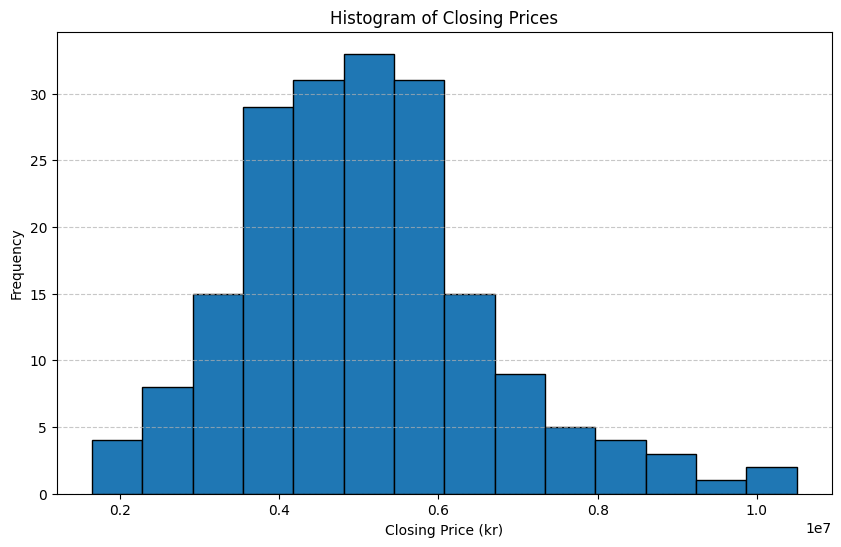

In [12]:
import matplotlib.pyplot as plt

# Freedman-Diaconis
iqr = q3 - q1
bin_width = 2 * iqr / (len(closing_prices) ** (1/3))
num_bins = int((closing_prices.max() - closing_prices.min()) / bin_width)

print(f"bin = {num_bins}")

plt.figure(figsize=(10, 6))
plt.hist(closing_prices, bins=num_bins, edgecolor='black')
plt.xlabel('Closing Price (kr)')
plt.ylabel('Frequency')
plt.title('Histogram of Closing Prices')
plt.grid(axis = 'y', linestyle='--', alpha=0.7)
plt.show()

## 2.3 scatter plot shows the relationship of the closing price with the boarea

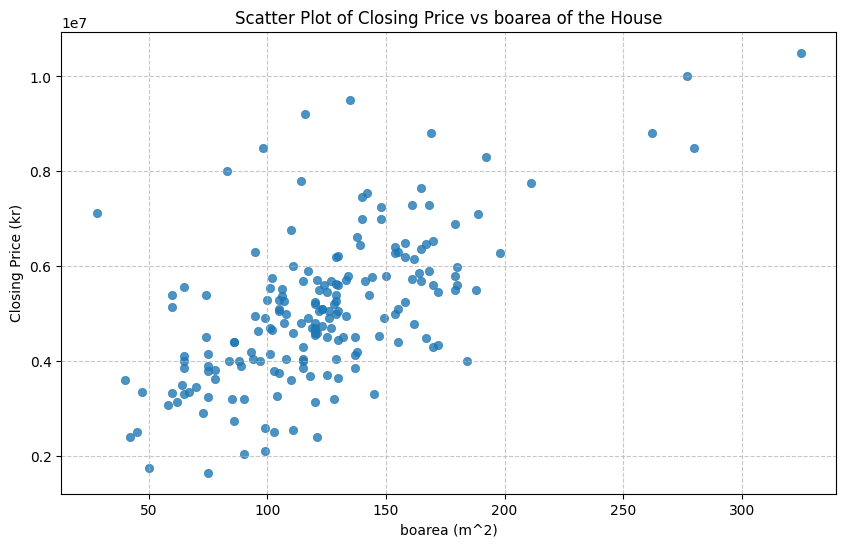

In [13]:
# get boarea
def extract_boarea(value):
    if isinstance(value, str):
        # replace ',' with '.'
        value = value.replace(',', '.')
        if '+' in value:
            # extract boarea from A + B
            boarea = value.split('+')[0]
            boarea = float(boarea)
            return boarea
        else:
            return float(value)
    elif isinstance(value, (int, float)):
        return float(value)
    else:
        return None

data['boarea (m^2)'] = data['Area (m^2)'].apply(extract_boarea)
data['Closing price (kr)'] = data['Closing price (kr)'].astype('int32')

plt.figure(figsize=(10, 6))
plt.scatter(data['boarea (m^2)'], data['Closing price (kr)'], alpha=0.8, linewidths=0.5)
plt.xlabel('boarea (m^2)')
plt.ylabel('Closing Price (kr)')
plt.title('Scatter Plot of Closing Price vs boarea of the House')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2.4 scatter plot which colorize the observations by the number of rooms

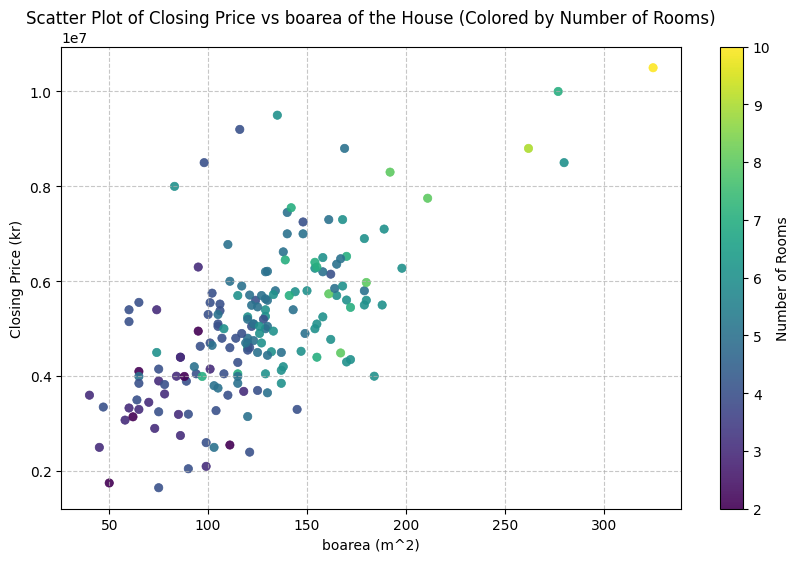

In [15]:
# colorize the plot based on the number of rooms
# change ',' to '.'
def convert_room(value) :
    if isinstance(value, str) :
        value = value.replace(',', '.')
        return float(value)
    elif isinstance(value, (int, float)):
        return float(value)
    else:
        return None

# convert the string to float
data['No. of rooms'] = data['No. of rooms'].apply(convert_room)

plt.figure(figsize=(10, 6))
sc = plt.scatter(data['boarea (m^2)'], data['Closing price (kr)'], c=data['No. of rooms'], cmap='viridis', alpha=0.9, linewidths=0.5)
plt.xlabel('boarea (m^2)')
plt.ylabel('Closing Price (kr)')
plt.title('Scatter Plot of Closing Price vs boarea of the House (Colored by Number of Rooms)')
plt.colorbar(sc, label='Number of Rooms')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2.5 Discuss shortly what the figures tell about the prices and the relationship between the different variables